# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. You will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. You will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

**Question 1**: What are the most common docks that are used over time and are they near any prominent landmarks?
    How old is each user in the bike-share system?


<a id='wrangling'></a>
## Data Collection and Wrangling

In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. 

**Question 2**: However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze. I will run the first code cell below to load some packages and functions that I'll be using in your analysis. Then, complete the second code cell to print out the first trip recorded from each of the cities (the second line of each data file).

In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.
import calendar

In [5]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## TODO: Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        
        ## TODO: Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = next(trip_reader)
        
        ## TODO: Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['NYC-CitiBike-2016.csv',
              'Chicago-Divvy-2016.csv',
              'Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip



City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

I will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, I will convert the Washington labels to match the other two.


**Question 3a**: What are the times of trips in seconds? What are the types of users for each city?(make sure that all user names are the same throughout each city)

In [11]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    HINT: The csv module reads in all of the data as strings, including numeric
    values. You will need a function to convert the strings into an appropriate
    numeric type when making your transformations.
    see https://docs.python.org/3/library/functions.html
    """
    # YOUR CODE HERE
    if city == 'Washington':
        seconds_object = int(datum['Duration (ms)'])
        duration = seconds_object / 60000
    else:
        seconds_object = int(datum['tripduration'])
        duration = seconds_object / 60
    return duration
   


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# I printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [12]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    """
        
        
    # YOUR CODE HERE
    if city == 'NYC':
        datetime_object = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M:%S')
    elif city == 'Chicago':
        datetime_object = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M')
    elif city == 'Washington':
        datetime_object = datetime.strptime(datum['Start date'], '%m/%d/%Y %H:%M')
    return ((datetime_object.month, datetime_object.hour, calendar.day_name[datetime_object.weekday()]))


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}
for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [10]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    # YOUR CODE HERE
    if city in ['Chicago', 'NYC']:
        return datum['usertype']
    elif city == 'Washington':
        if datum['Member Type'] == 'Registered': 
            user_type = 'Subscriber'
        elif datum['Member Type'] == 'Casual':
            user_type = 'Customer'
    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}
for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Question 3b**: By using the helper functions above, create a condensed data file for each city that has only the data types we are looking for - duration of trip, type of user, and month, hour, day of week.

In [13]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## TODO: set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point

            new_point = {}

            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above. ##
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'] = time_of_trip(row, city)
            new_point['hour'] = time_of_trip(row, city)
            new_point['day_of_week'] = time_of_trip(row, city)
            new_point['user_type'] = type_of_user(row, city)
            

            ## TODO: write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)

            

In [50]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', "(3, 22, 'Thursday')"),
             ('hour', "(3, 22, 'Thursday')"),
             ('day_of_week', "(3, 22, 'Thursday')"),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', "(3, 23, 'Thursday')"),
             ('hour', "(3, 23, 'Thursday')"),
             ('day_of_week', "(3, 23, 'Thursday')"),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', "(1, 0, 'Friday')"),
             ('hour', "(1, 0, 'Friday')"),
             ('day_of_week', "(1, 0, 'Friday')"),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that we have the data collected and wrangled, we're ready to start exploring the data. In this section I will write some code to compute descriptive statistics from the data. I will also create some histograms from 'matplotlib' for the data files.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. 

**Question 4a**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answer**: New York City has the highest number of trips. New York City has the highest total number of trips made by subscribers. Chicago has the highest proportion of trips made by short-term customers.

In [14]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

In [16]:
# I will run this cell for an example of what the output will look like on the city files.
data_file = 'BayArea-Y3-Summary.csv'
print(number_of_trips(data_file))

(5666, 633, 6299)


In [19]:
city_files = [['Washington', 'Registered', 'Washington-2016-Summary.csv'],
             ['Chicago', 'Subscriber', 'Chicago-2016-Summary.csv'],
             ['New York', 'Subscriber', 'NYC-2016-Summary.csv']]
def number_of_trips_updated(filename, user):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
        
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # compute the proportion of trips made by subscribers, rounded to 3 decimals
        subscribers_proportion = round(n_subscribers / n_total, 3)
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total, subscribers_proportion)

In [20]:
print('The number of trips made by subscribers, customers, the total overall and \n'
      'the proportion of trips made by the subscribers are:')
print("" )

for entry in city_files:
    print('For {}: {}'.format(entry[0], number_of_trips_updated(entry[2], entry[1])))

The number of trips made by subscribers, customers, the total overall and 
the proportion of trips made by the subscribers are:

For Washington: (51753, 14573, 66326, 0.78)
For Chicago: (54982, 17149, 72131, 0.762)
For New York: (245896, 30902, 276798, 0.888)


**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**: The average trip length for Washington, Chicago, and New York is 18.93 minutes, 16.56 minutes, and 15.81 minutes respectively. The proportion of rides that are longer than 30 minutes for Washington, Chicago, and New York City is 10.8%, 8.3%, and 7.3% respectively.

In [21]:
## The csv module reads in all of the data as strings, including        ##
## numeric values. I will need a function to convert the strings        ##
## into an appropriate numeric type before aggregating the data.        ##

city_files = [['Washington', 'Registered', 'Washington-2016-Summary.csv'],
             ['Chicago', 'Subscriber', 'Chicago-2016-Summary.csv'],
             ['New York', 'Subscriber', 'NYC-2016-Summary.csv']]
def average_duration(filename, city):
    """
    This function reads in a file with trip data and the corresponding city, 
    and reports average duration 
    and the percentage of trips that are longer than 30 minutes.
    """
        
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        tot_duration = 0
        longer_trips = 0
        
        # get the sum of all trip durations and the number of trips loger than 30 minutes
        # round to 3 decimals
        for row in reader:
            tot_duration = tot_duration + round(float(row['duration']),3)
            if float(row['duration']) > 30:
                longer_trips = longer_trips + 1
        
        # get the total number of rides, using a previously defined function
        for entry in city_files:
            if city ==entry[0]: 
                n_total = number_of_trips_updated(filename, entry[1])[2]
        
        
        # return the average duration and the proportion of trips loger than 30 minutes 
        return(round(tot_duration/n_total, 3), round(longer_trips/n_total, 3))
    
print('The average trip length for each city, followed by \n''the proportion of rides made in each city that are longer than 30 minutes:')
print("")

for entry in city_files:
    print('For {}: {}'.format(entry[0], average_duration(entry[2], entry[0])))

The average trip length for each city, followed by 
the proportion of rides made in each city that are longer than 30 minutes:

For Washington: (18.933, 0.108)
For Chicago: (16.564, 0.083)
For New York: (15.813, 0.073)


**Question 4c**: I will dig deeper into the question of trip duration based on ridership. By choosing Chicago for example, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: Customers take more trips than subscribers on average. Within Chicago, customers take on average twice as long as subscribers.

In [22]:
## I will use this function to answer question 4c ##

city_files = [['Washington', 'Registered', 'Washington-2016-Summary.csv'],
             ['Chicago', 'Subscriber', 'Chicago-2016-Summary.csv'],
             ['New York', 'Subscriber', 'NYC-2016-Summary.csv']]
def average_duration_split(city, user, filename):
    """
    This function reads an entry in city_files and reports 
    the average length for trips made by subscribers and
    the average trip length for trips made by short term customers.
    """
        
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        duration_subscriber = 0
        duration_customer = 0
        
        # find totals for trips durations, by user type
        for row in reader:
            if row['user_type'] == 'Subscriber':
                duration_subscriber = duration_subscriber + round(float(row['duration']),3)
            else:
                duration_customer = duration_customer + round(float(row['duration']),3)
        
        # get total number of rides for each type of rider
        for entry in city_files:
            if city == entry[0]: 
                n_subscribers = number_of_trips_updated(entry[2], entry[1])[0]
                n_customers = number_of_trips_updated(entry[2], entry[1])[1]
        
        # return the averages as a tuple
        return(round(duration_subscriber/n_subscribers,3), round(duration_customer/n_customers,3))


In [23]:
### print the information obtained from average_duration_split function for each city
print('The average trip length for each city, split by type of users,\n'
      'for Subscribers and for short-term Customers:')
print("")

for entry in city_files:
    print('For {}: {}'.format(entry[0], average_duration_split(entry[0], entry[1], entry[2])))

The average trip length for each city, split by type of users,
for Subscribers and for short-term Customers:

For Washington: (12.528, 41.678)
For Chicago: (12.067, 30.98)
For New York: (13.681, 32.776)


<a id='visualizations'></a>
### Visualizations

The last set of values that I computed have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. 

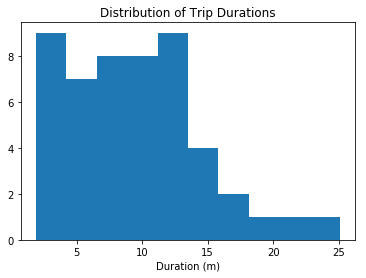

In [25]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook.
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

I will now use these functions to create a histogram of the trip times for the city I selected in question 4c.

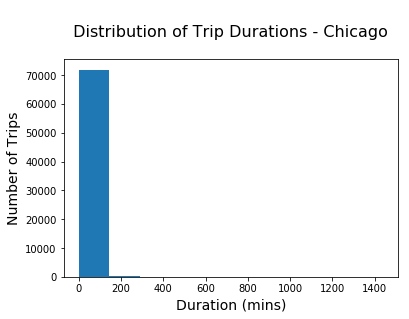

In [27]:
## I will collect all of the trip times as a list and then use ##
## pyplot functions to generate a histogram of trip times.     ##

with open(city_files[1][2], 'r') as f_in:
    # set up csv reader object
    reader = list(csv.DictReader(f_in))
        
### create an empty list for the data to be saved in
times_list = []

### save all the trip durations, as float numbers in a list
for i in range(0, len(reader)):
    times_list.append(float(reader[i]['duration']))
            
### a naive histogram of the trip durations, all riders in Chicago 

plt.hist(times_list)

### title and axes labelling
plt.title('\n Distribution of Trip Durations - Chicago \n', fontsize=16)
plt.xlabel('Duration (mins)', fontsize = 14)
plt.ylabel('Number of Trips', fontsize = 14)
plt.show()


The plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. Take a look at the duration values on the x-axis. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, I will use additional parameters with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

**Question 5**: We will use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers and Customers in Chicago. This time, we will add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, we will set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

**Answer**: Peak distribution of number of trips is at 1272 trips for Subscribers. These peak number of trips last between 5-10 minutes. For Customers, peak distribution of number of trips is 1432 and these trips last between 20-25 minutes. Both graphs are positively skewed.

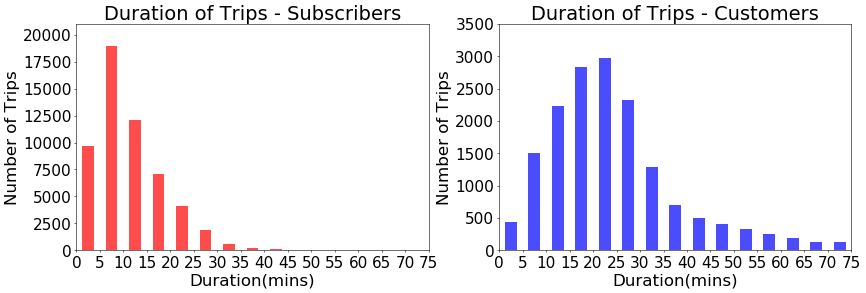

In [30]:
## This cell will take in the duration of each city and output a histogram of the duration of ##
## Subscribers and Customers in Chicago.                                                      ##

def durations_list(entry):
    # set up csv reader object
    with open(entry[2], 'r') as f_in:
        reader = list(csv.DictReader(f_in))
        
        # create empty lists for each rider type
        total_riders = [] 
        subscribers = [] 
        customers = [] 
        
        # tally up all the duration times for each user type
        for i in range(0, len(reader)):
            total_riders.append(float(reader[i]['duration']))   
            if reader[i]['user_type'] == entry[1]:
                subscribers.append(float(reader[i]['duration']))
            else:
                customers.append(float(reader[i]['duration']))
        return(total_riders, subscribers, customers)

# set up city_files for the histogram
city_files = [['Washington', 'Registered', 'Washington-2016-Summary.csv'],
             ['Chicago', 'Subscriber', 'Chicago-2016-Summary.csv'],
             ['New York', 'Subscriber', 'NYC-2016-Summary.csv']]   

# run the function above for the city of chicago
chicago_total = durations_list(city_files[1])[0]
chicago_subscribers = durations_list(city_files[1])[1]
chicago_customers = durations_list(city_files[1])[2]   

# run the necessary packages
import matplotlib.pyplot as plt
% matplotlib inline

# set up histogram characteristics
x_labels = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
plt.figure(figsize=(20, 6), dpi= 50, linewidth=4, frameon=True)

# set titles and axes for the Subscribers histogram
plt.subplot(1,2,1)
plt.hist(chicago_subscribers, facecolor='r', alpha= 0.7, bins=x_labels, rwidth=0.5)
plt.title('Duration of Trips - Subscribers', fontsize=28)
plt.xlabel('Duration(mins)', fontsize=24)
plt.ylabel('Number of Trips', fontsize=24)
plt.axis([0,75,0,21000])
plt.xticks(x_labels, fontsize=22)
plt.yticks(fontsize=22)

# set up titles and axes for the Customers histogram
plt.subplot(1,2,2)
plt.hist(chicago_customers, facecolor='b', alpha=0.7, bins=x_labels, rwidth=0.5)
plt.title('Duration of Trips - Customers', fontsize=28)
plt.xlabel('Duration(mins)', fontsize=24)
plt.ylabel('Number of Trips', fontsize=24)
plt.axis([0,75,0,3500])
plt.xticks(x_labels, fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [39]:
print('The maximum number of trips for Subscribers during peak is {}:'.format(max(chicago_subscribers)))
print('The maximum number of trips for Customers during peak is {}:'.format(max(chicago_customers)))

The maximum number of trips for Subscribers during peak is 1272.45:
The maximum number of trips for Customers during peak is 1439.4166666666667:


<a id='eda_continued'></a>
## Performing A Final Analysis

So far, we've performed an initial exploration into the data available. We have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For Chicago, we have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now it is time to explore a final question.

**Question 6**: How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?

**Answer**: Ridership differs each season in that the most number of riders occur in the summer months with the least in winter months. June has the highest number of riders. There is approximately double the amount of Subscribers to Customers in the summer months. In the winter months, there is approximately a 1:0 ratio of Subscribers to Customers.

In [31]:
def condense_Chicago(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week','user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## TODO: set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above. ##
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'] = time_of_trip(row, city)[0]
            new_point['hour'] = time_of_trip(row, city)[1]
            new_point['day_of_week'] = time_of_trip(row, city)[2]
            new_point['user_type'] = type_of_user(row, city)
            

            ## TODO: write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)                                    ##

In [34]:
# This will create a new file from the Chicago city file#
in_file_Chicago = 'Chicago-Divvy-2016.csv'
out_file_Chicago = 'Chicago-Divvy-2016-updated.csv'

# Perform the helper function stated above #
condense_Chicago(in_file_Chicago, out_file_Chicago, 'Chicago')

In [35]:
# we will need to index the months 
months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# create empty lists for each user type 
monthly_subs = [] 
monthly_cust = [] 
monthly_total = []

def monthly_trips(month):
    """ 
    This function takes in the month and data from specified input file and 
    outputs the number of user types by month.
    """
    # set up csv dictReader object
    with open(out_file_Chicago, 'r') as f_in:
        reader = csv.DictReader(f_in)

        # start tally count at 0
        trips_Subs = 0
        trips_Cust = 0
        
        # tally up the number of user types
        for row in reader:
            if row['month'] == month and row['user_type'] == 'Subscriber':
                trips_Subs += 1
            if row['month'] == month and row['user_type'] == 'Customer':
                trips_Cust += 1
        
        # create a total count        
        trips_total = trips_Subs + trips_Cust
        
        # return the counted groups
        return(trips_Subs, trips_Cust, trips_total)

# this loop will takes in month and outputs of 'monthly_trips' function
# and output the monthly type of users.
for i in months:
    monthly_subs.append(monthly_trips(i)[0])
    monthly_cust.append(monthly_trips(i)[1])
    monthly_total.append(monthly_trips(i)[2])
#optional test
#print(monthly_subs)
#print(monthly_cust)
#print(monthly_total)

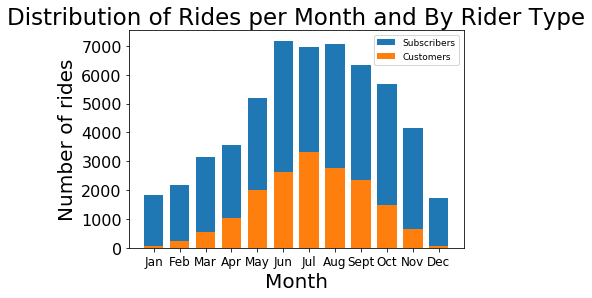

In [38]:
# import necessary packages and functions
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# name all months for the x labels later
month=('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec')

# set up the x-ticks
N=12
ind = np.arange(N)
width =0.75

# set up the y-ticks
heights_subs = monthly_subs
heights_cust = monthly_cust

# plot the both bar charts 
bar_1 = plt.bar(ind, heights_subs, width=0.75)
bar_2 = plt.bar(ind, heights_cust, width=0.75)

# set up the x and y ticks
plt.xticks(ind, month, fontsize = 12) 
plt.yticks(fontsize=16)

# set up the titles and axes
plt.title('Distribution of Rides per Month and By Rider Type', fontsize=23)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of rides', fontsize=20)

# create a legend for the bar chart
plt.legend((bar_1[0], bar_2[0]), ('Subscribers', 'Customers'), fontsize=9, loc=1)

# use the magic word to create the bar chart
plt.show()

<a id='conclusions'></a>
## Conclusions

**Question 7**: Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**: I would like to apply data science techniques to psychology. For example, I would like to apply predictive analytics to the language that schizophrenics use to detect when they are about to have a relapse.

> **Tip**:

> If you are working on this project via the Project Notebook page in the classroom, you can also submit this project directly from the workspace. **Before you do that**, you should save an HTML copy of the completed project to the workspace by running the code cell below. If it worked correctly, the output code should be a 0, and if you click on the jupyter icon in the upper left, you should see your .html document in the workspace directory. Alternatively, you can download the .html copy of your report following the steps in the previous paragraph, then _upload_ the report to the directory (by clicking the jupyter icon).

> Either way, once you've gotten the .html report in your workspace, you can complete your submission by clicking on the "Submit Project" button to the lower-right hand side of the workspace.

In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

255